# 深度学习模型
特征：
1. 滑动窗口采样
设置windows size，采样前k个step预测下一个

2. 滑动窗口平均采样

模型：
1. MLP
2. CNN
3. LSTM
4. RCNN
5. RWKV

todo：
1. 加入额外特征embedding

In [1]:
import pandas as pd
import numpy as np
import random
import pickle
import math
import os
import scipy.io
import matplotlib.pyplot as plt
%matplotlib inline

from math import sqrt
from datetime import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [2]:
from dataclasses import dataclass

# 1 读取处理后数据

字典数据：
```
{
    'tid':[
        [cycle_count],
        [battery_life]
    ]
}
```

DataFrame数据：
```
columns = [tid,cycle_count,life]
```

In [3]:
bmap = pickle.load(open("../data/processed/nasa-li-battery_dict_240906.pkl",'rb'))

In [4]:
# ddf = pd.read_pickle('../data/processed/nasa-li-battery_df_240906.pkl')

# 2 特征采样和评价指标

## 2.1 特征采样

In [5]:
def build_sequences(text, window_size):
    #text:list of capacity
    x, y = [],[]
    for i in range(len(text) - window_size):
        sequence = text[i:i+window_size]
        target = text[i+1:i+1+window_size]

        x.append(sequence)
        y.append(target)
        
    return np.array(x), np.array(y)


# 留一评估：一组数据为测试集，其他所有数据全部拿来训练
def get_train_test(data_dict, name, window_size=8, train_ratio=0.):
    data_sequence=data_dict[name][1]
    train_data, test_data = data_sequence[:window_size+1], data_sequence[window_size+1:]
    train_x, train_y = build_sequences(text=train_data, window_size=window_size)
    for k, v in data_dict.items():
        if k != name:
            data_x, data_y = build_sequences(text=v[1], window_size=window_size)
            train_x, train_y = np.r_[train_x, data_x], np.r_[train_y, data_y]
            
    return train_x, train_y, list(train_data), list(test_data)


def evaluation(y_test, y_predict):
    mae = mean_absolute_error(y_test, y_predict)
    mse = mean_squared_error(y_test, y_predict)
    rmse = sqrt(mean_squared_error(y_test, y_predict))
    return mae, rmse
    

def relative_error(y_test, y_predict, threshold):
    true_re, pred_re = len(y_test), 0
    for i in range(len(y_test)-1):
        if y_test[i] <= threshold >= y_test[i+1]:
            true_re = i - 1
            break
    for i in range(len(y_predict)-1):
        if y_predict[i] <= threshold:
            pred_re = i - 1
            break
    return abs(true_re - pred_re)/true_re

## 2.2 训练和评价

In [6]:
from tqdm import tqdm

### 绘图函数

In [7]:
def plot(name,
         real_data, 
         pred_data):
    fig, ax = plt.subplots(1, figsize=(12, 8))

    plot_range = [i for i in range(len(real_data))]
    
    ax.plot(plot_range, real_data, 'b.', label=name)
    ax.plot(plot_range, pred_data, 'r.', label='Prediction')
    plt.plot([-1,170],[2*0.7, 2*0.7], c='black', lw=1, ls='--')  # 临界点直线
    ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Capacity degradation at ambient temperature of 24°C')
    plt.legend()

# 3 RNN

RNN取最后一个step接linear输出。

后续可考虑LSTM和attention。

In [8]:
from typing import List,Dict,Tuple

In [9]:
from collections import OrderedDict

In [10]:
import torch

In [11]:
class NASALiBatteryDataset(torch.utils.data.Dataset):
    def __init__(self, 
                 fpath:str,
                ):
        
        x_lst,y_lst = [],[]
        self.data_dict = pickle.load(open(fpath,'rb'))
        for name in self.data_dict.keys():
            train_x, train_y, train_data, test_data = get_train_test(self.data_dict, name, window_size)
            real_train_y = np.expand_dims(train_y[:,-1],-1)
            x_lst.append(train_x)
            y_lst.append(real_train_y)
        self.train_x = np.vstack(x_lst)
        self.train_y = np.vstack(y_lst)
        
    def __len__(self):
        return self.train_x.shape[0]
        
    def __getitem__(self, indices):
        
        return np.take(self.train_x,axis=0,indices=indices), np.take(self.train_y,axis=0,indices=indices)

In [12]:
class BaseModel(torch.nn.Module):

    def __init__(self, 
                 prefix_length:int=1,
                 device:str='cpu'):
        super(BaseModel, self).__init__()
        
        self.prefix_length = prefix_length
        self.device = device
    def __post_init__(self):
        self.double()
        
    def decode(self,
               input_x:np.array,
               max_length:int):
        '''
        input_x: List(prefix_length, )
        max_length: target decode length
        '''
        if not self.prefix_length != len(input_x):
            assert(f'Error input sequence must be prefix_length shape:{self.prefix_length}')

        test_x = input_x
        
        # decode to target length
        for i in range(max_length+1):
            online_x = np.array(test_x[-self.prefix_length:])
            online_x = torch.tensor(online_x).reshape((1,online_x.shape[0])).double().to(self.device)
            test_x += self.forward(online_x).flatten().detach().numpy().tolist() #测试值加入原来序列用来继续预测下一个点

        # list
        return test_x
        
    def forward(self, 
                x:torch.Tensor):
        '''
        x: (prefix_length, )
        '''
        pass

In [107]:
seq_length = 32
qk_dim = 27
v_dim = 16
feature_size = 15

In [108]:
test = torch.rand((64,seq_length,feature_size))

tensor([[2.2444e-02, 7.2334e-06, 4.4520e-08,  ..., 1.7668e+00, 8.5258e-03,
         2.9210e-11],
        [1.0293e-04, 7.6019e-10, 6.8511e-05,  ..., 5.4977e-06, 1.1236e-13,
         9.6503e-14],
        [1.1169e-15, 2.4231e-14, 5.8862e-13,  ..., 4.2319e-08, 2.3968e-15,
         4.9414e-09],
        ...,
        [2.8327e-01, 5.1940e-10, 2.9674e-04,  ..., 2.4121e-02, 1.1275e-10,
         1.1343e+02],
        [1.3729e-08, 5.1293e-08, 2.6458e-06,  ..., 7.7526e-09, 4.7116e-11,
         3.5908e-09],
        [6.4114e-12, 4.5240e-09, 2.6529e-14,  ..., 1.9229e-14, 1.5990e-08,
         4.8074e-13]], grad_fn=<SqueezeBackward0>)

In [195]:
class RNNATTModel(BaseModel):

    def __init__(self,
                 feature_size:int,
                 qk_dim:int,
                 v_dim:int,
                 num_layers:int=1,
                 prefix_length:int=1,
                 device:str='cpu'):
        super(RNNATTModel, self).__init__(
            prefix_length=prefix_length,
               device=device
        )
        self.feature_size = feature_size
        self.qk_dim = qk_dim
        self.v_dim = v_dim
        # 只有一个channel 所以默认input_size和hidden_size为1，没啥需要设置的参数
        self.RNNLayer = torch.nn.RNN(input_size=1,
                                                hidden_size=self.prefix_length,
                                                num_layers=num_layers,
                                                batch_first=True,
                                                dropout=0.5,
                                                bidirectional=False)
        
        
        self.wq = torch.nn.Parameter(torch.rand((self.qk_dim,self.feature_size)))
        self.wk = torch.nn.Parameter(torch.rand((self.qk_dim,self.feature_size)))
        self.wv = torch.nn.Parameter(torch.rand((self.v_dim,self.feature_size)))
        
        self.OutLinearLayer = torch.nn.Linear(in_features=self.prefix_length,
                                              out_features=1)
        
        self.__post_init__()

    def SelfAttention(self,
                      x:torch.Tensor):
        
        kval = x.matmul(self.wk.T)
        qval = x.matmul(self.wq.T)
        vval = x.matmul(self.wv.T)

        omega = qval.matmul(torch.einsum('ijk->ikj',kval))
        
        omega = omega/np.sqrt(self.qk_dim)
        
        omega = torch.nn.functional.softmax(omega,1)
        
        att_out = omega.matmul(vval)
        
        pool_out = torch.nn.AvgPool1d(kernel_size=self.v_dim)(att_out).squeeze()

        return pool_out
        
    def forward(self,
                x:torch.Tensor):
        x = x.reshape(x.shape[0],x.shape[1],1)
        
        out, _ = self.RNNLayer(x)       # out shape: (batch_size, feature_size, hidden_dim)
        self_out = self.SelfAttention(out)
        y = self.OutLinearLayer(self_out)      # out shape: (batch_size, 1)
        
        return y

In [196]:
window_size = 32
epoch = 10_00_000
learning_rate = 1e-4    # learning rate
weight_decay = 0.0
feature_size = 32
qk_dim = 32
v_dim = 16
num_layers = 2
batch_size = 512

In [197]:
eval_step = 1000

In [198]:
data_dict = bmap

In [202]:
model = RNNATTModel(feature_size=feature_size,
                 qk_dim=qk_dim,
                    v_dim=v_dim,
                    num_layers=num_layers,
                 prefix_length=window_size)

In [206]:
optimizer = torch.optim.Adam(model.parameters(), 
                             lr=learning_rate, 
                             weight_decay=weight_decay)
criterion = torch.nn.MSELoss()

In [207]:
on_test_log = True

In [208]:
train_dataset = NASALiBatteryDataset(fpath='../data/processed/nasa-li-battery_dict_240906.pkl')

In [209]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=False)

In [210]:
loss_list = [0]
mae_lst,rmse_lst = [], []

for i in tqdm(range(epoch)):
    if i%eval_step==0 and on_test_log:
        print('---------------------------------------------------')
    for batch_x,batch_y in train_loader:
        output= model(batch_x)
        loss = criterion(output, batch_y)
        optimizer.zero_grad()              # clear gradients for this training step
        loss.backward()                    # backpropagation, compute gradients
        optimizer.step()                   # apply gradients

        loss_list.append(loss.detach().numpy().tolist())

    if i%eval_step==0:
        for name in data_dict.keys():
            train_x, train_y, train_data, test_data = get_train_test(data_dict, name, window_size)
            
            prefix_x = data_dict[name][1][:window_size]
            decode_seq = model.decode(prefix_x,max_length=len(test_data))[window_size+1:]
            mae, rmse = evaluation(y_test=test_data, y_predict=decode_seq)
            
            mae_lst.append(mae)
            rmse_lst.append(rmse)
        
        if on_test_log:
            print(f'Epoch:{i} Loss:{np.average(loss_list):.8f} MAE:{np.average(mae_lst):.4f} | RMSE:{np.average(rmse_lst):.4f}')

  0%|          | 0/1000000 [00:00<?, ?it/s]

---------------------------------------------------


  0%|          | 3/1000000 [00:00<54:14:51,  5.12it/s] 

Epoch:0 Loss:3.55145936 MAE:1.6083 | RMSE:1.7614


  0%|          | 999/1000000 [01:13<20:33:53, 13.49it/s]

---------------------------------------------------


  0%|          | 1003/1000000 [01:13<32:49:19,  8.45it/s]

Epoch:1000 Loss:0.10465619 MAE:0.8390 | RMSE:0.9219


  0%|          | 1999/1000000 [02:26<20:03:07, 13.83it/s]

---------------------------------------------------


  0%|          | 2003/1000000 [02:27<32:19:53,  8.57it/s]

Epoch:2000 Loss:0.05346659 MAE:0.5772 | RMSE:0.6350


  0%|          | 2999/1000000 [03:40<19:37:52, 14.11it/s]

---------------------------------------------------


  0%|          | 3003/1000000 [03:40<32:31:39,  8.51it/s]

Epoch:3000 Loss:0.03613245 MAE:0.4469 | RMSE:0.4918


  0%|          | 3999/1000000 [04:53<21:07:22, 13.10it/s]

---------------------------------------------------


  0%|          | 4003/1000000 [04:54<31:43:16,  8.72it/s]

Epoch:4000 Loss:0.02740916 MAE:0.3696 | RMSE:0.4069


  0%|          | 4999/1000000 [06:07<19:49:51, 13.94it/s]

---------------------------------------------------


  1%|          | 5003/1000000 [06:07<31:26:28,  8.79it/s]

Epoch:5000 Loss:0.02211832 MAE:0.3184 | RMSE:0.3507


  1%|          | 5999/1000000 [07:20<20:02:59, 13.77it/s]

---------------------------------------------------


  1%|          | 6003/1000000 [07:21<32:58:12,  8.37it/s]

Epoch:6000 Loss:0.01856944 MAE:0.2833 | RMSE:0.3119


  1%|          | 6999/1000000 [08:34<20:15:40, 13.61it/s]

---------------------------------------------------


  1%|          | 7003/1000000 [08:34<31:52:24,  8.65it/s]

Epoch:7000 Loss:0.01602475 MAE:0.2557 | RMSE:0.2818


  1%|          | 7999/1000000 [09:47<19:45:17, 13.95it/s]

---------------------------------------------------


  1%|          | 8003/1000000 [09:47<30:45:47,  8.96it/s]

Epoch:8000 Loss:0.01411018 MAE:0.2344 | RMSE:0.2585


  1%|          | 8999/1000000 [11:00<20:21:48, 13.52it/s]

---------------------------------------------------


  1%|          | 9003/1000000 [11:01<33:42:49,  8.17it/s]

Epoch:9000 Loss:0.01261744 MAE:0.2174 | RMSE:0.2399


  1%|          | 9999/1000000 [12:13<20:06:53, 13.67it/s]

---------------------------------------------------


  1%|          | 10003/1000000 [12:14<31:03:39,  8.85it/s]

Epoch:10000 Loss:0.01142054 MAE:0.2033 | RMSE:0.2245


  1%|          | 10999/1000000 [13:27<20:09:09, 13.63it/s]

---------------------------------------------------


  1%|          | 11003/1000000 [13:27<32:59:53,  8.33it/s]

Epoch:11000 Loss:0.01043936 MAE:0.1909 | RMSE:0.2109


  1%|          | 11999/1000000 [14:40<20:08:20, 13.63it/s]

---------------------------------------------------


  1%|          | 12003/1000000 [14:41<31:57:08,  8.59it/s]

Epoch:12000 Loss:0.00962011 MAE:0.1808 | RMSE:0.1998


  1%|▏         | 12999/1000000 [15:54<19:59:49, 13.71it/s]

---------------------------------------------------


  1%|▏         | 13003/1000000 [15:54<31:43:19,  8.64it/s]

Epoch:13000 Loss:0.00892554 MAE:0.1761 | RMSE:0.1948


  1%|▏         | 13999/1000000 [17:07<20:09:00, 13.59it/s]

---------------------------------------------------


  1%|▏         | 14003/1000000 [17:07<31:28:45,  8.70it/s]

Epoch:14000 Loss:0.00832920 MAE:0.1684 | RMSE:0.1864


  1%|▏         | 14999/1000000 [18:20<19:50:53, 13.79it/s]

---------------------------------------------------


  2%|▏         | 15003/1000000 [18:21<31:44:25,  8.62it/s]

Epoch:15000 Loss:0.00781159 MAE:0.1608 | RMSE:0.1780


  2%|▏         | 15999/1000000 [19:33<20:33:51, 13.29it/s]

---------------------------------------------------


  2%|▏         | 16003/1000000 [19:34<32:30:29,  8.41it/s]

Epoch:16000 Loss:0.00735762 MAE:0.1553 | RMSE:0.1720


  2%|▏         | 16999/1000000 [20:46<19:58:37, 13.67it/s]

---------------------------------------------------


  2%|▏         | 17003/1000000 [20:47<32:15:43,  8.46it/s]

Epoch:17000 Loss:0.00695652 MAE:0.1505 | RMSE:0.1669


  2%|▏         | 17999/1000000 [22:00<20:03:11, 13.60it/s]

---------------------------------------------------


  2%|▏         | 18003/1000000 [22:01<31:09:14,  8.76it/s]

Epoch:18000 Loss:0.00659939 MAE:0.1464 | RMSE:0.1624


  2%|▏         | 19000/1000000 [37:38<20:28:07, 13.31it/s] 

---------------------------------------------------


  2%|▏         | 19002/1000000 [37:39<37:23:47,  7.29it/s]

Epoch:19000 Loss:0.00627950 MAE:0.1418 | RMSE:0.1574


  2%|▏         | 20000/1000000 [38:52<20:18:26, 13.41it/s]

---------------------------------------------------


  2%|▏         | 20002/1000000 [38:53<37:35:17,  7.24it/s]

Epoch:20000 Loss:0.00599102 MAE:0.1373 | RMSE:0.1524


  2%|▏         | 21000/1000000 [40:06<20:29:41, 13.27it/s]

---------------------------------------------------


  2%|▏         | 21002/1000000 [40:07<37:23:14,  7.27it/s]

Epoch:21000 Loss:0.00572965 MAE:0.1335 | RMSE:0.1483


  2%|▏         | 22000/1000000 [41:20<19:50:22, 13.69it/s]

---------------------------------------------------


  2%|▏         | 22002/1000000 [41:20<36:54:39,  7.36it/s]

Epoch:22000 Loss:0.00549151 MAE:0.1300 | RMSE:0.1445


  2%|▏         | 23000/1000000 [42:34<21:06:28, 12.86it/s]

---------------------------------------------------


  2%|▏         | 23002/1000000 [42:34<39:45:04,  6.83it/s]

Epoch:23000 Loss:0.00527360 MAE:0.1265 | RMSE:0.1407


  2%|▏         | 24000/1000000 [43:48<19:49:19, 13.68it/s]

---------------------------------------------------


  2%|▏         | 24002/1000000 [43:48<36:49:47,  7.36it/s]

Epoch:24000 Loss:0.00507332 MAE:0.1248 | RMSE:0.1388


  2%|▎         | 25000/1000000 [45:02<19:25:25, 13.94it/s]

---------------------------------------------------


  3%|▎         | 25002/1000000 [45:02<35:55:48,  7.54it/s]

Epoch:25000 Loss:0.00488860 MAE:0.1223 | RMSE:0.1361


  3%|▎         | 26000/1000000 [46:15<19:46:06, 13.69it/s]

---------------------------------------------------


  3%|▎         | 26002/1000000 [46:16<36:16:33,  7.46it/s]

Epoch:26000 Loss:0.00471771 MAE:0.1209 | RMSE:0.1346


  3%|▎         | 27000/1000000 [47:29<19:46:11, 13.67it/s]

---------------------------------------------------


  3%|▎         | 27002/1000000 [47:30<36:06:20,  7.49it/s]

Epoch:27000 Loss:0.00455907 MAE:0.1204 | RMSE:0.1340


  3%|▎         | 28000/1000000 [48:43<20:12:39, 13.36it/s]

---------------------------------------------------


  3%|▎         | 28002/1000000 [48:44<37:01:26,  7.29it/s]

Epoch:28000 Loss:0.00441146 MAE:0.1179 | RMSE:0.1313


  3%|▎         | 29000/1000000 [49:58<19:33:21, 13.79it/s]

---------------------------------------------------


  3%|▎         | 29004/1000000 [49:58<31:14:29,  8.63it/s]

Epoch:29000 Loss:0.00427375 MAE:0.1153 | RMSE:0.1285


  3%|▎         | 30000/1000000 [51:12<19:19:48, 13.94it/s]

---------------------------------------------------


  3%|▎         | 30002/1000000 [51:13<36:58:56,  7.29it/s]

Epoch:30000 Loss:0.00414497 MAE:0.1130 | RMSE:0.1260


  3%|▎         | 31000/1000000 [52:26<20:59:57, 12.82it/s]

---------------------------------------------------


  3%|▎         | 31002/1000000 [52:27<36:52:05,  7.30it/s]

Epoch:31000 Loss:0.00402434 MAE:0.1107 | RMSE:0.1235


  3%|▎         | 32000/1000000 [53:40<19:29:42, 13.79it/s]

---------------------------------------------------


  3%|▎         | 32002/1000000 [53:40<36:25:51,  7.38it/s]

Epoch:32000 Loss:0.00391107 MAE:0.1101 | RMSE:0.1228


  3%|▎         | 33000/1000000 [54:54<19:34:59, 13.72it/s]

---------------------------------------------------


  3%|▎         | 33002/1000000 [54:54<36:22:07,  7.39it/s]

Epoch:33000 Loss:0.00380453 MAE:0.1080 | RMSE:0.1205


  3%|▎         | 34000/1000000 [56:07<19:11:47, 13.98it/s]

---------------------------------------------------


  3%|▎         | 34002/1000000 [56:08<36:48:18,  7.29it/s]

Epoch:34000 Loss:0.00370412 MAE:0.1063 | RMSE:0.1186


  4%|▎         | 35000/1000000 [57:21<19:35:13, 13.69it/s]

---------------------------------------------------


  4%|▎         | 35002/1000000 [57:21<36:11:39,  7.41it/s]

Epoch:35000 Loss:0.00360933 MAE:0.1061 | RMSE:0.1185


  4%|▎         | 36000/1000000 [58:35<20:25:34, 13.11it/s]

---------------------------------------------------


  4%|▎         | 36002/1000000 [58:35<36:20:41,  7.37it/s]

Epoch:36000 Loss:0.00351969 MAE:0.1047 | RMSE:0.1169


  4%|▎         | 37000/1000000 [59:48<19:47:48, 13.51it/s]

---------------------------------------------------


  4%|▎         | 37002/1000000 [59:49<36:32:26,  7.32it/s]

Epoch:37000 Loss:0.00343481 MAE:0.1034 | RMSE:0.1156


  4%|▍         | 38000/1000000 [1:01:02<19:26:28, 13.75it/s]

---------------------------------------------------


  4%|▍         | 38002/1000000 [1:01:03<35:00:19,  7.63it/s]

Epoch:38000 Loss:0.00335432 MAE:0.1020 | RMSE:0.1140


  4%|▍         | 39000/1000000 [1:02:16<19:09:36, 13.93it/s]

---------------------------------------------------


  4%|▍         | 39002/1000000 [1:02:16<36:38:46,  7.28it/s]

Epoch:39000 Loss:0.00327789 MAE:0.1017 | RMSE:0.1137


  4%|▍         | 40000/1000000 [1:03:29<19:42:01, 13.54it/s]

---------------------------------------------------


  4%|▍         | 40002/1000000 [1:03:30<36:21:53,  7.33it/s]

Epoch:40000 Loss:0.00320521 MAE:0.1007 | RMSE:0.1126


  4%|▍         | 41000/1000000 [1:04:43<19:26:28, 13.70it/s]

---------------------------------------------------


  4%|▍         | 41002/1000000 [1:04:44<38:03:24,  7.00it/s]

Epoch:41000 Loss:0.00313600 MAE:0.0995 | RMSE:0.1113


  4%|▍         | 41225/1000000 [1:05:00<25:11:58, 10.57it/s]


KeyboardInterrupt: 

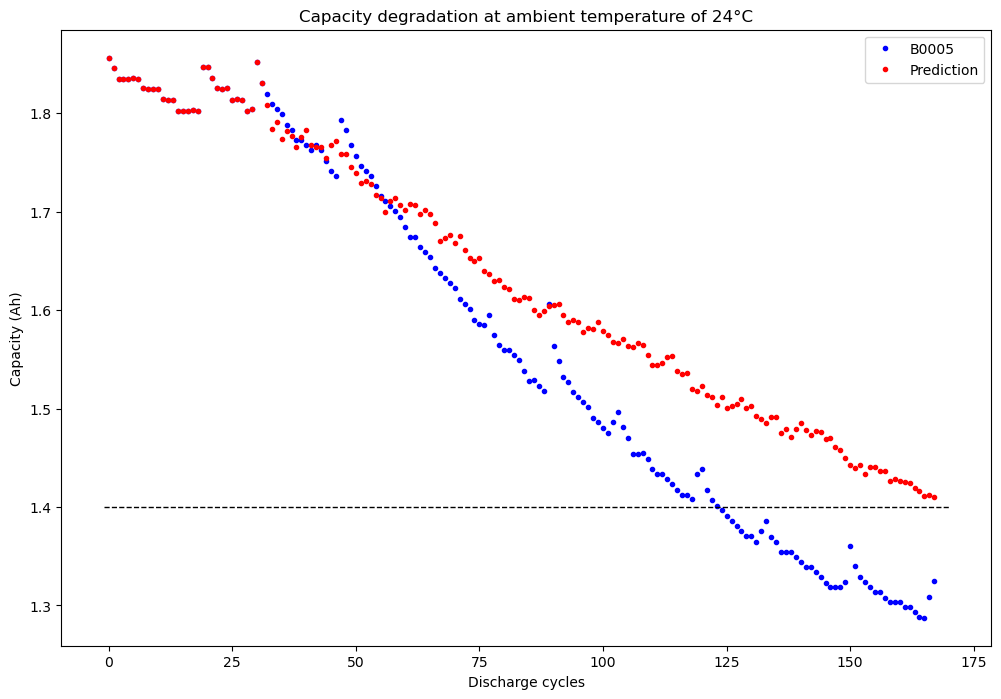

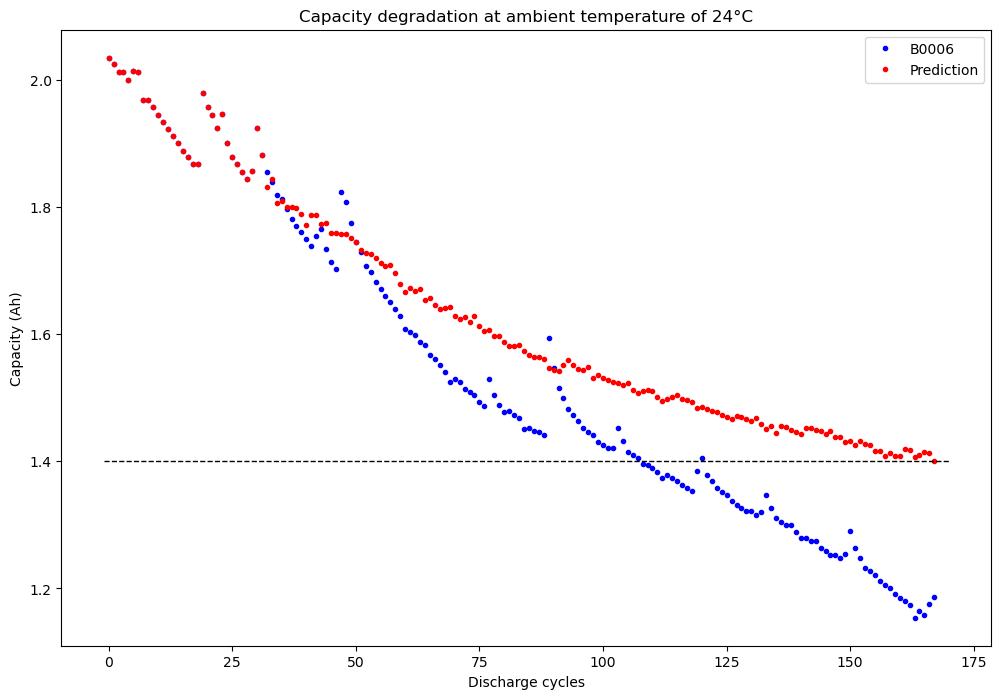

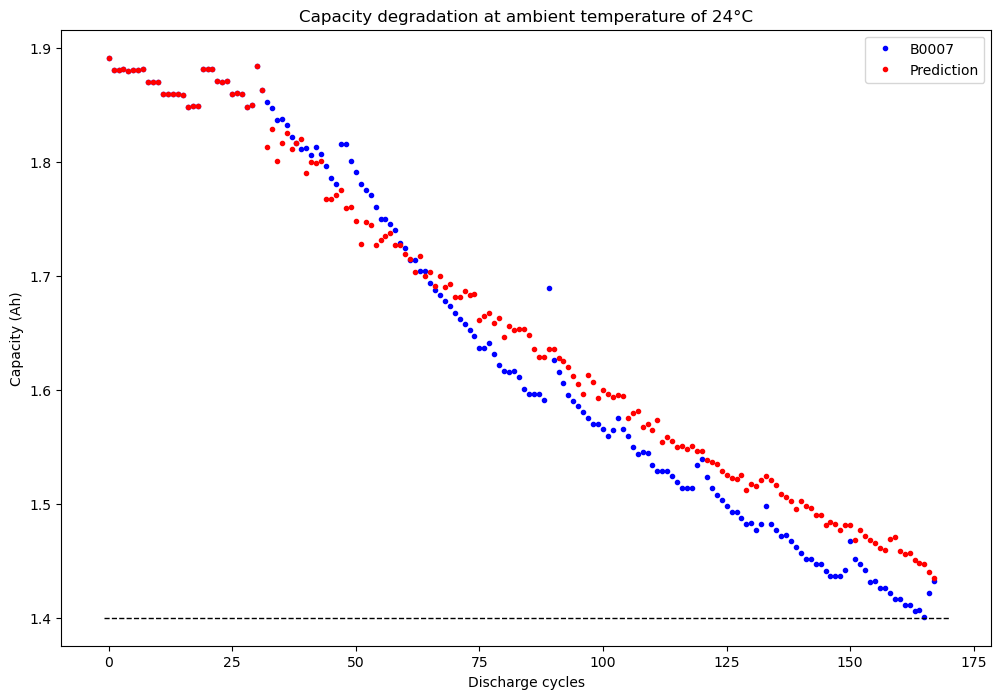

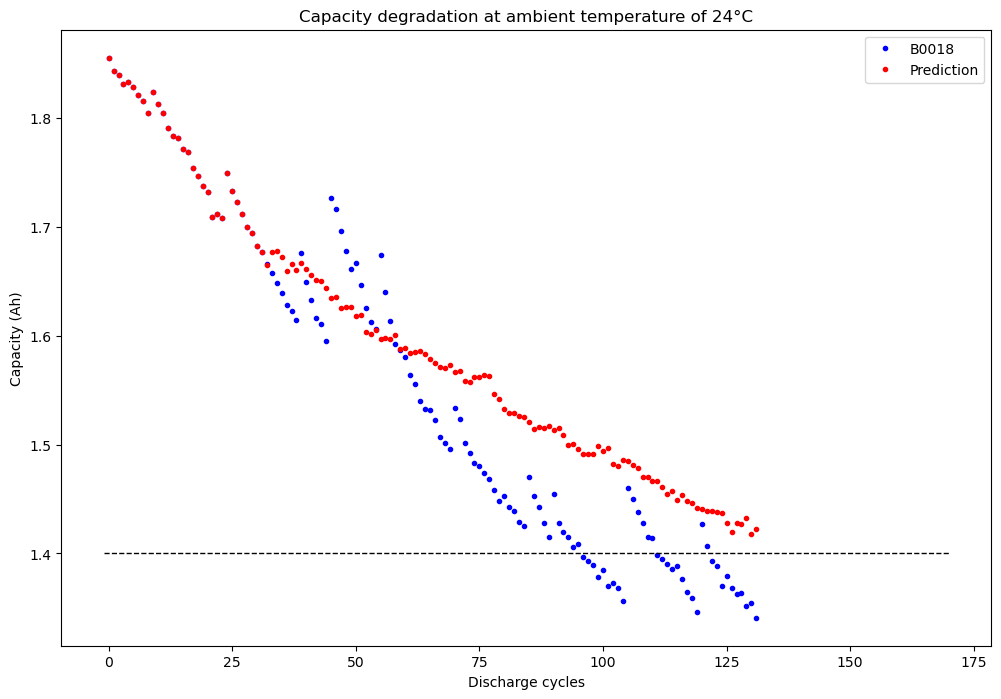

In [211]:
for name in data_dict.keys():
    train_x, train_y, train_data, test_data = get_train_test(data_dict, name, window_size)

    real = data_dict[name][1]
    prefix_x = data_dict[name][1][:window_size]
    decode_seq = model.decode(prefix_x,max_length=len(test_data))
    
    plot(name=name,
         real_data=real,
        pred_data=decode_seq)